In [8]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import netCDF4 as nc
import data_generate.data_processing as data_processing
import geopandas as gpd
import pandas as pd
import xarray as xr
from copy import deepcopy
import scipy.stats as stats
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, BatchNormalization, Activation, LeakyReLU, Dropout, LSTM, Reshape
from tensorflow.keras.models import Model
from tensorflow_probability import distributions as tfd

C:\Users\96349\anaconda3\envs\Downscale_env\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\96349\anaconda3\envs\Downscale_env\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\96349\anaconda3\envs\Downscale_env\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\96349\anaconda3\env

## 1. data prepare

In [12]:
# read downscale data
d_filepath = r"C:\Users\96349\Documents\Downscale_data\Downscaled_data\downscaled.nc"
d_data = nc.Dataset(d_filepath, 'r')
# high resolution
h_lats = d_data.variables['lat'][:]
h_lons = d_data.variables['lon'][:]

# read MERRA 2 data
m_filepath = r"C:\Users\96349\Documents\Downscale_data\MERRA2\MERRA2_aerosol_variables_over_MiddleEast_daily_20000516-20180515.nc"
m_data = nc.Dataset(m_filepath, 'r')
# low resolution
l_lats = m_data.variables['lat'][:]
l_lons = m_data.variables['lon'][:]

# read shape file
country_shape_path = r'C:\Users\96349\Documents\Downscale_data\Country_shape\KWT_adm\KWT_adm0.shp'
country_shape = gpd.read_file(country_shape_path)

# read dust day data
dust_day_table = pd.read_excel(r'C:\Users\96349\OneDrive - University of Southern California\Desktop\Downscaling_Project\DustDayCheck\dust_0016.xlsx')
dust_day_table['date'] = pd.to_datetime(dust_day_table['date'])
dust_day_table = dust_day_table[dust_day_table['date'] >= pd.datetime(2000, 5, 16)]
dust_day_table['day_index'] = (dust_day_table['date'] - pd.datetime(2000, 5, 16)).dt.days

C:\Users\96349\anaconda3\envs\Downscale_env\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """
C:\Users\96349\anaconda3\envs\Downscale_env\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
C:\Users\96349\anaconda3\envs\Downscale_env\lib\site-packages\ipykernel_launche

In [19]:
# get a mean series of given area, from start to the end
def get_mean_series(dust_data,start, end, lats, lons, country_shape):
    temp = []
    for i in range(start, end):
        image, sub_lat, sub_lon = data_processing.country_filter(dust_data[i], lats,
                                                                lons, country_shape)
        temp.append(np.nanmean(image))
    return temp

# check series
def series_check(series_data, title):
    plt.plot(series_data)
    plt.title(title)
    plt.show()
    plt.close()

    plt.hist(series_data)
    plt.title(title+'_distribution')
    plt.show()
    plt.close()

In [22]:
target_variable = 'BCSMASS'
g_var_data = d_data.variables[target_variable][:]
#m_var_data = m_data.variables[target_variable][:]
start = 728
end = 728+730
g_kuwait_series = get_mean_series(g_var_data, start, end, h_lats, h_lons, country_shape)
#m_kuwait_series = get_mean_series(m_var_data, start, end, l_lats, l_lons, country_shape)

C:\Users\96349\anaconda3\envs\Downscale_env\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


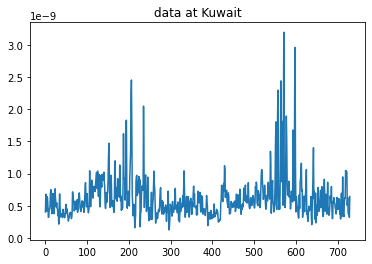

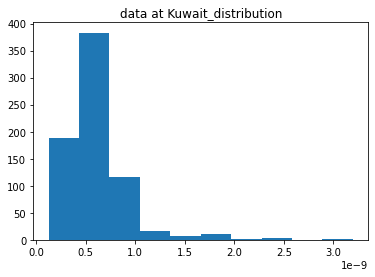

In [23]:
series_check(g_kuwait_series, 'data at Kuwait')

## 2. define model

In [105]:
def unit_layer(nodes, input, with_dropout=False, activation='LeakyReLU'):
    if activation == 'LeakyReLU':
        x = layers.Dense(nodes, kernel_initializer="he_normal", use_bias=True)(input)
        x = BatchNormalization()(x)
        if with_dropout:
            x = Dropout(0.5)(x)
        x = LeakyReLU(alpha=0.1)(x)
    else:
        x = layers.Dense(nodes, kernel_initializer="he_normal", activation=activation, use_bias=True)(input)
        x = BatchNormalization()(x)
        if with_dropout:
            x = Dropout(0.5)(x)
    return x

def temporal_block(input):
    x = LSTM(8, return_sequences=True, activation=LeakyReLU(), use_bias=True, kernel_initializer="he_normal")(
                input)
    x = LSTM(16, return_sequences=True, activation=LeakyReLU(), use_bias=True, kernel_initializer="he_normal")(
                x)
    x = LSTM(32, activation=LeakyReLU(), use_bias=True, kernel_initializer="he_normal")(x)
    x = unit_layer(16, x)
            # x = Reshape((1, 16))(x)
            # x = Lambda(lambda y: K.batch_flatten(y))(x)
    return x

def process_block(input):
    x = unit_layer(8, input)
    x = unit_layer(8, x)
    x = unit_layer(16, x)
    x = unit_layer(16, x)
    x = unit_layer(16, x)
    return x

def nnelu(input):
    return tf.add(tf.constant(1, dtype=tf.float32), tf.nn.elu(input))

components = 1
no_parameters = 3
def slice_parameter_vectors(parameter_vector):
    return [parameter_vector[:, i * components:(i + 1) * components] for i in range(no_parameters)]

def gnll_loss(y, parameter_vector):
    alpha, mu, sigma= slice_parameter_vectors(parameter_vector)  # Unpack parameter vectors

    gm = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=alpha),
        components_distribution=tfd.LogitNormal(
        loc=mu, scale=sigma, allow_nan_stats=False))

    log_likelihood = gm.log_prob(tf.transpose(y))  # Evaluate log-probability of y

    return -tf.reduce_mean(log_likelihood, axis=-1)

tf.keras.utils.get_custom_objects().update({'nnelu': Activation(nnelu)})

In [102]:
# NN model
input1 = Input(shape=(1, 25))
encode1 = temporal_block(input1)
X = unit_layer(32, encode1)
X = unit_layer(16, X)
X = unit_layer(8, X)
output1= layers.Dense(1, activation='relu')(X)
NN_model = Model(input1, output1)
NN_model.compile(optimizer='adam', loss="mean_squared_error")
NN_model.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 1, 25)]           0         
                                                                 
 lstm_43 (LSTM)              (None, 1, 8)              1088      
                                                                 
 lstm_44 (LSTM)              (None, 1, 16)             1600      
                                                                 
 lstm_45 (LSTM)              (None, 32)                6272      
                                                                 
 dense_60 (Dense)            (None, 16)                528       
                                                                 
 batch_normalization_56 (Bat  (None, 16)               64        
 chNormalization)                                                
                                                          

In [106]:
# MDN model
input2 = Input(shape=(1,25))
encode2 = temporal_block(input2)
X = unit_layer(32, encode2)
X = unit_layer(16, X)
X = unit_layer(8, X)
alphas = layers.Dense(components, activation="softmax", name="alphas")(X)
mus = layers.Dense(components,name="mus")(X)
sigmas = layers.Dense(components, activation="nnelu", name="sigmas")(X)
output = layers.Concatenate()([alphas, mus, sigmas])
MDN_model = Model( input2, output)
MDN_model.compile(optimizer='adam', loss=gnll_loss)
MDN_model.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 1, 25)]      0           []                               
                                                                                                  
 lstm_49 (LSTM)                 (None, 1, 8)         1088        ['input_18[0][0]']               
                                                                                                  
 lstm_50 (LSTM)                 (None, 1, 16)        1600        ['lstm_49[0][0]']                
                                                                                                  
 lstm_51 (LSTM)                 (None, 32)           6272        ['lstm_50[0][0]']                
                                                                                           

## 3. train and validate

In [62]:
dataset = np.zeros((len(g_kuwait_series), 1))
dataset[:, 0] = g_kuwait_series
#scaler = MinMaxScaler(feature_range=(0, 1))
max_v = dataset.max()
min_v = dataset.min()
dataset = (dataset - min_v)/(max_v - min_v)
# split into train and test sets
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

look_back = 25
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX = np.expand_dims(trainX, 1)
testX = np.expand_dims(testX, 1)

510 220


In [67]:
NN_history = NN_model.fit(trainX, trainY, epochs=10, batch_size=20, verbose=2)

Epoch 1/10
25/25 - 4s - loss: 0.1187 - 4s/epoch - 168ms/step
Epoch 2/10
25/25 - 0s - loss: 0.0353 - 59ms/epoch - 2ms/step
Epoch 3/10
25/25 - 0s - loss: 0.0302 - 58ms/epoch - 2ms/step
Epoch 4/10
25/25 - 0s - loss: 0.0292 - 54ms/epoch - 2ms/step
Epoch 5/10
25/25 - 0s - loss: 0.0285 - 57ms/epoch - 2ms/step
Epoch 6/10
25/25 - 0s - loss: 0.0267 - 59ms/epoch - 2ms/step
Epoch 7/10
25/25 - 0s - loss: 0.0261 - 64ms/epoch - 3ms/step
Epoch 8/10
25/25 - 0s - loss: 0.0254 - 61ms/epoch - 2ms/step
Epoch 9/10
25/25 - 0s - loss: 0.0243 - 63ms/epoch - 3ms/step
Epoch 10/10
25/25 - 0s - loss: 0.0248 - 63ms/epoch - 3ms/step


In [107]:
MDN_histroy = MDN_model.fit(trainX, trainY, epochs=10, batch_size=20, verbose=2)

Epoch 1/10
25/25 - 4s - loss: nan - 4s/epoch - 174ms/step
Epoch 2/10
25/25 - 0s - loss: nan - 63ms/epoch - 3ms/step
Epoch 3/10
25/25 - 0s - loss: nan - 58ms/epoch - 2ms/step
Epoch 4/10
25/25 - 0s - loss: nan - 60ms/epoch - 2ms/step
Epoch 5/10
25/25 - 0s - loss: nan - 66ms/epoch - 3ms/step
Epoch 6/10
25/25 - 0s - loss: nan - 68ms/epoch - 3ms/step
Epoch 7/10
25/25 - 0s - loss: nan - 67ms/epoch - 3ms/step
Epoch 8/10
25/25 - 0s - loss: nan - 65ms/epoch - 3ms/step
Epoch 9/10
25/25 - 0s - loss: nan - 70ms/epoch - 3ms/step
Epoch 10/10
25/25 - 0s - loss: nan - 65ms/epoch - 3ms/step


In [88]:
NN_Yhat = NN_model.predict(testX)
MDN_Yhat = MDN_model.predict(testX)
alpha_pred, mu_pred= slice_parameter_vectors(MDN_Yhat)
MDN_Yhat = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=alpha_pred),
        components_distribution=tfd.Exponential(
            rate=mu_pred))


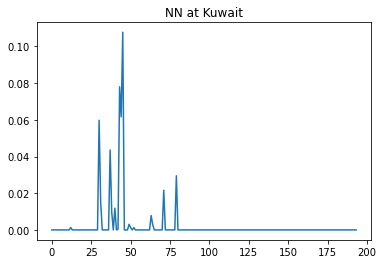

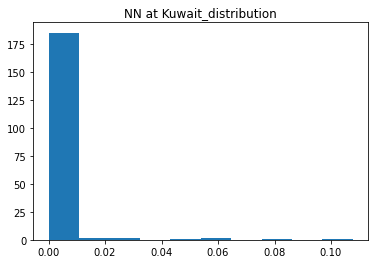

In [83]:
series_check(NN_Yhat, 'NN at Kuwait')

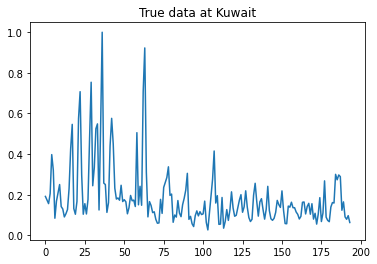

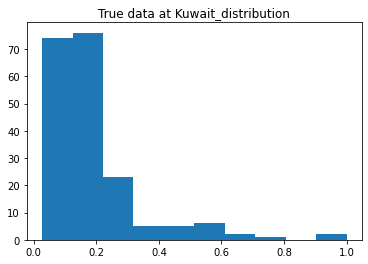

In [84]:
series_check(testY, 'True data at Kuwait')

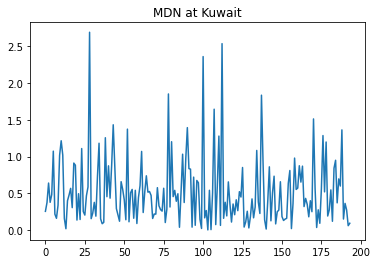

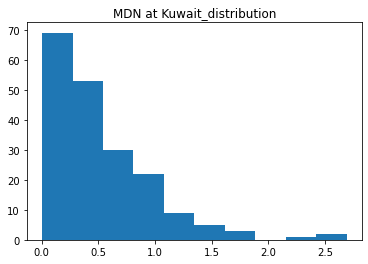

In [89]:
series_check(np.asarray(MDN_Yhat.sample()), 'MDN at Kuwait')